<a href="https://colab.research.google.com/github/LindeBee/thesisFinal/blob/main/DFS_112_building.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### DigiMat Pro: Navier-Stokes fluid flow Direct FEM Simulation (DFS)



<p>Incompressible Navier-Stokes as model for low and high Reynolds number flow, such as blood flow and flight (first principles: conservation of mass and momentum): <span class="math display">\begin{array}{rcll} 
R(\hat{u}) &;=&
\begin{cases}
  \partial_t u + (u\cdot \nabla) u + \nabla p - \nu \Delta u = 0\\
  \nabla \cdot u = 0
\end{cases}\\
u &;=& 0, x \in \Gamma \quad (\text{No-slip BC for low Reynolds number})\\
\hat{u} &=& (u, p), \quad r(\hat{u}, \hat{v}) = (R(\hat{u}), \hat{v}) \quad (\text{Weak residual})
\end{array}</span></p>
<dl>
<dt>Space-time cG(1)cG(1) FEM with GLS stabilization. Developed over 20+ years by Johnson, Hoffman, Jansson, etc.</dt>
<dd><p><span class="math display">\begin{aligned}
  &r(\hat{U}, \hat{v}) = (R(\hat{U}), \hat{v}) + (\delta R(\hat{U}), R(\hat{v})) = 0\\
  &\delta = h, \, \forall \hat{v} \in \hat{V}_h, \, \hat{U} \in \hat{V}_h\end{aligned}</span></p>
</dd>

### FEniCS DFS formulation to run and modify yourself

 ### Step 0: Prepare environment


In [1]:
# Setup system environment and define utility functions and variables
from google.colab import files
from google.colab import drive
# to save files directly to google drive:
# drive.mount('/content/gdrive')

try:
    import dolfin
except ImportError as e:
    # Add FEniCS PPA to Ubuntu and install (Python3.6)
    !echo deb http://ppa.launchpad.net/fenics-packages/fenics/ubuntu bionic main >> /etc/apt/sources.list
    !apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 2C5275D7EF63D9DE2D28D3702940F5212B746472
    !apt-get -qq update

    !apt-get -y install fenics > /dev/null

    # Reinstall dolfin for Python3.7
    !rm -r /usr/lib/petsc/lib/python3/dist-packages/dolfin
    !git clone https://bitbucket.org/fenics-project/dolfin
    !cd dolfin/python && python3 setup.py install

    # Reinstall mpi4py for Python3.7
    !rm -r /usr/lib/python3/dist-packages/mpi4py*
    !pip3 install mpi4py --upgrade
    
    !rm -rf /usr/lib/python3/dist-packages/petsc4py*
    !rm -rf /usr/lib/python3/dist-packages/slepc4py*
    !rm -rf /usr/lib/petsc/lib/python3/dist-packages/mshr*
    !wget "https://drive.google.com/uc?export=download&id=119i49bxlGn1mrnhTNmOvM4BqmjrT9Ppr" -O /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-1tVfu8qz3bRC2zvR8n3RESpesWqNnn6" -O /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl
    !wget "https://drive.google.com/uc?export=download&id=1-5SMjgjMuee_9WLeYtGe8N_lvipWEN7W" -O /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl
    !pip3 install /tmp/petsc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/slepc4py-3.7.0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 install /tmp/mshr-2019.2.0.dev0-cp37-cp37m-linux_x86_64.whl --upgrade
    !pip3 -q install --upgrade sympy
    import dolfin

!mkdir results
!mkdir images

!pip3 install gmsh
!apt-get install python-lxml
!git clone https://github.com/LindeBee/pvScripts.git
!wget -c -O ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz 'https://www.paraview.org/paraview-downloads/download.php?submit=Download&version=v5.9&type=binary&os=Linux&downloadFile=ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz'
!tar xzvf ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit.tar.gz --skip-old-files
!pwd
!cat /proc/cpuinfo

!pip3 uninstall -y h5py 
!pip3 uninstall -y meshio
!pip3 install --no-binary=h5py h5py
!pip3 install --no-cache-dir meshio==3.2.7

  Created wheel for h5py: filename=h5py-3.5.0-cp37-cp37m-linux_x86_64.whl size=4689208 sha256=074a0d47eff5ad09e6ae3be193cbbf25b23ed706840125a00098a77c981a50fe
  Stored in directory: /root/.cache/pip/wheels/c3/b8/89/d9491e2a48ce1a663bf2ac36c0b0f978d3d242f6592c3e61d8
Successfully built h5py
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.6.0 requires h5py~=3.1.0, but you have h5py 3.5.0 which is incompatible.
     |████████████████████████████████| 180 kB 5.4 MB/s 


### Step 1: Create geometry and mesh


In [ ]:
%%writefile geo_var.py

b_h = 2 # maximum heigh of geometry
b_l = 1 # lenth in x-direction of whole geometry
b_w = 1 # width in y-direction of whole geometry
# limits of the domain
xmin = -(6.*b_h+.5*b_l); xmax = (15.*b_h+.5*b_l)
ymin = -(5.*b_h+.5*b_w); ymax = (5.*b_h+.5*b_w)
zmin = 0.; zmax = 6.*b_h
# limits of the area of interest
xmin_phi = -0.75*b_h; xmax_phi = 1.75*b_h
ymin_phi = -1.0*b_h; ymax_phi = 1.0*b_h
zmin_phi = 0; zmax_phi = 1.5*b_h

nu = 1.0/56000

Writing geo_var.py


In [ ]:
# add gmsh to python path
import sys
sys.path.append("/usr/local/lib/python3.7/site-packages/gmsh-4.8.4-Linux64-sdk/lib")

In [ ]:
# simple 2:1:1 block mesh
import sys

from gmsh import *

initialize(sys.argv)

from geo_var import *

model.add("newModel")
b1 = model.occ.addBox(-.5*b_l, -0.5*b_w, 0, b_l, b_w, b_h, 1) # building
b2 = model.occ.addBox(xmin_phi, ymin_phi, zmin_phi, xmax_phi-xmin_phi, ymax_phi-ymin_phi, zmax_phi-zmin_phi,2) # box for marker target functional
b3 = model.occ.addBox(xmin, ymin, zmin, xmax-xmin, ymax-ymin, zmax-zmin,3) # limits of domain

# cut and combine boxes into domain
b4 = model.occ.cut([(3,3)], [(3,2)], 4, True, False)
b5 = model.occ.cut([(3,2)], [(3,1)], 5, True, True)
model.occ.fragment([(3,4)], [(3,5)])
model.occ.synchronize()

model.addPhysicalGroup(3, [4,5], 1)

# field for mesh size
model.mesh.field.add("MathEval", 1)
model.mesh.field.setString(1, "F", "(sqrt((x/2)^2+y^2+max(0,z-"+str(b_h)+")^2+1))^1.5/10") # change to alter density of initial mesh
model.mesh.field.setAsBackgroundMesh(1)

# generate 3 dimensional mesh
model.mesh.generate(3)
write("mesh.msh")

finalize()

import meshio
from dolfin import *
import numpy as np

# convert output to xdmf 
mesh = meshio.read(
    "mesh.msh",  # string, os.PathLike, or a buffer/open file
)
mesh_of_tetras = meshio.Mesh(points=mesh.points[:, :3], 
                             cells={'tetra': mesh.cells['tetra']},
                             cell_data={'tetra': {'subdomain': mesh.cell_data['tetra']['gmsh:physical']}},
                             field_data=mesh.field_data) 

meshio.write("results/mesh.xdmf", mesh_of_tetras )

In [ ]:
from IPython.display import Image
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython pvScripts/surface_mesh.py
!cp images/surfaceMesh.png surfaceMeshBefore.png #copy outside of images folder so it won't get removed
# visualisation of the geometry
Image('surfaceMeshBefore.png', width = 1000)

### Step 2: Compile simulation files

###2.1 timestep on current mesh

In [ ]:
%%writefile timestep.py

# Copyright (c) 2017-2018 Johan Jansson, Mans Andersson, Cem Degirmenci, David Kamensky, FEniCS community contributions 
from dolfin import *
from ufl import replace
from mshr import *
import time
import os.path
import csv

tt1 = time.process_time();
# Set option to allow extrapolation
parameters["allow_extrapolation"] = True

from geo_var import *

eps = 1e-5;
k_max = 1.; k_min = 0.05;
T = 60.;  # Time interval
out_t = 0.; freq = 0.01 #output frequency, if freq < k_min save all timesteps
c1 = 1. # stabilization parameter
c1min = 1.; c1max = 5.

if os.path.isfile('results/mesh.xdmf'):
  print("found mesh")
  mesh = Mesh()
  with XDMFFile("results/mesh.xdmf") as infile:
    infile.read(mesh)
else: 
  print("No mesh available")
  exit()

if os.path.isfile('results/timestamp.txt'):
  with open('results/timestamp.txt','r') as tfile:
    t = float(tfile.readline())
    T = t+T
else:
  t = 0.

if MPI.comm_world.rank ==0:
  if not os.path.isfile('results/mean_vel.csv'):
    with open('results/mean_vel.csv','w') as csvfile:
      linewriter = csv.writer(csvfile)
      linewriter.writerow(['time', '<U/uH>'])

print("num vertices:", MPI.sum(MPI.comm_world, mesh.num_vertices()))

# define function spaces
VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1);
ZE = FiniteElement("DG", mesh.ufl_cell(), 0);
V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE); Z = FunctionSpace(mesh, ZE); 
# FEM functions
v = TestFunction(V); q = TestFunction(Q); 
utr = TrialFunction(V); ptr = TrialFunction(Q) 
u = Function(V); u0 = Function(V); u00 = Function(V); p = Function(Q); p0 = Function(Q); p00 = Function(Q); # solution, solution last timestep, solution last solver iteration
up = Function(V); pp = Function(Q); # primal problem
udiff = Function(V); pdiff = Function(Q); # difference to solution last solver iteration
h = CellDiameter(mesh); 

# inflow profile
# uin = Expression(('pow(x[2]/2,0.25)', '0.', '0.'), element = V.ufl_element()) # Power law
# uin = Expression(('(1/std::log((2+0.09)/0.09))*std::log((x[2]+0.09+0.2)/0.09)-0.03', '0.', '0.'), element = V.ufl_element()) # custom 1
uin = Expression(('(1/std::log((2+0.1)/0.1))*std::log((x[2]+0.1+0.2)/0.1)/1.15+0.1', '0.', '0.'), element = V.ufl_element()) # custom 2

pzero = Expression("0.", element = Q.ufl_element())

# z normal
n_z = Expression(('0.','0.','1.'), element = V.ufl_element()) 

# mark regions for week boundary conditions
nm = Expression("x[2]>eps && x[0] > xmin+eps && x[0] < xmax-eps", eps=eps, xmin=xmin, xmax=xmax, element = Q.ufl_element()) # object boundary
gb = Expression("x[2] < eps ? 1. : 0.", eps=eps, xmin=xmin, xmax=xmax, element = Q.ufl_element())

# mark area of interest
marker = Expression('x[0]> xmin_phi-eps && x[1] > ymin_phi-eps && x[2] > zmin_phi-eps && x[0] < xmax_phi+eps && x[1] < ymax_phi+eps && x[2] <zmax_phi+eps ? 1.0 : 0.0', eps=eps, xmin_phi = xmin_phi, ymin_phi = ymin_phi, zmin_phi = zmin_phi, xmax_phi = xmax_phi, ymax_phi = ymax_phi, zmax_phi = zmax_phi, element = Q.ufl_element()) # marker for evaluation mean velocity area of interest 

# define inflow boundary
class InflowBoundary(SubDomain):                                                                         
    def inside(self, x, on_boundary):                                                                     
        return x[0] < xmin+b_h or (on_boundary and (x[1]<ymin + eps or x[1]>ymax-eps or x[2]> zmax -eps or x[0]>xmax-eps)) 

stepcounter = 0; 
 
import time
 
class RUCProblem(NonlinearProblem):
    def __init__(self, J, F, bcs):
        self.bilinear_form = J
        self.linear_form = F
        self.bcs = bcs
        NonlinearProblem.__init__(self)
 
    def F(self, b, x):
        ta1 = time.process_time();
        assemble(self.linear_form, tensor=b)
        ta2 = time.process_time();
        # print("RUC assemble vector timer:" + str(ta2 - ta1));
        for bc in self.bcs:
            bc.apply(b, x)
 
    def J(self, A, x):
        ta1 = time.process_time();
        assemble(self.bilinear_form, tensor=A)
        ta2 = time.process_time();
        # print("RUC assemble matrix timer:" + str(ta2 - ta1));
        for bc in self.bcs:
            bc.apply(A)

class RUCSolver(NewtonSolver):
    def __init__(self):
        NewtonSolver.__init__(self, MPI.comm_world,
                              PETScKrylovSolver(), PETScFactory.instance())

    def solver_setup(self, A, P, problem, iteration):
        self.linear_solver().set_operator(A)

        #PETScOptions.set("ksp_type", "gmres")
        PETScOptions.set("ksp_type", "tfqmr")
        #PETScOptions.set("ksp_monitor")
        #PETScOptions.set("pc_type", "hypre")
        #PETScOptions.set("pc_type", "sor")
        PETScOptions.set("pc_type", "pbjacobi")
        #PETScOptions.set("pc_hypre_type", "sor")

        PETScOptions.set("ksp_rtol", "1e-1")
        PETScOptions.set("ksp_atol", "1e-1")

        self.linear_solver().parameters["nonzero_initial_guess"] = True

        self.linear_solver().set_from_options()

    def converged(self, r, problem, iteration):
        return (iteration > 0)

u_out = Function(V)
xdmf_file_u = XDMFFile("results/u.xdmf")
xdmf_file_u.parameters["flush_output"] = True
xdmf_file_u.parameters["functions_share_mesh"] = True
xdmf_file_u.parameters["rewrite_function_mesh"] = False

p_out = Function(Q)
xdmf_file_p = XDMFFile("results/p.xdmf")
xdmf_file_p.parameters["flush_output"] = True
xdmf_file_p.parameters["functions_share_mesh"] = True
xdmf_file_p.parameters["rewrite_function_mesh"] = False


hmin = MPI.min(MPI.comm_world, mesh.hmin());
print("hmin:", hmin);
k = min(10*hmin,k_max);
gamma = 1e2*1./(1*h); wgamma = 1./(1*h) # penalty parameter

# tolerance for difference between previous and current solution
rdtol = 1e-2 # 1%

one = Constant(1.0)
vol = marker*one*dx(domain=mesh)
volume = assemble(vol)
print("Volume:", volume)

nn = FacetNormal(mesh);
n = Function(V);

# Weak normal projection
rwn = dot(n, v)*dx + 1e2/(1*h)*dot(n-nn, v)*ds # residual weak normal
J = derivative(rwn, n)
bcs = []
rucproblem = RUCProblem(J, rwn, bcs)
rucsolver = RUCSolver()
rucsolver.parameters["relative_tolerance"] = 1e-6;
#rucsolver.parameters["maximum_iterations"] = 1;
ts1 = time.process_time();
rucsolver.solve(rucproblem, n.vector())
ts2 = time.process_time();
print("Normal projection solve timer:" + str(ts2 - ts1));

xdmf_file_n = XDMFFile("results/n.xdmf")
xdmf_file_n.parameters["flush_output"] = True
xdmf_file_n.parameters["functions_share_mesh"] = True
xdmf_file_n.parameters["rewrite_function_mesh"] = False

n.rename("n", "")
xdmf_file_n.write(n, t)

udiffnorm = 0.0
unorm = 1.0

pdiffnorm = 0.0
p00diffnorm = 0.0
pnorm = 1.0
udiffrel = 0
pdiffrel = 0

# prime the whole domain so that u = uin everywhere
ap0 = inner(utr, v)*dx
Lp0 = inner(uin, v)*dx
Ap0, bp0 = assemble_system(ap0, Lp0, [])
mysolver = KrylovSolver('gmres','amg')
mysolver.solve(Ap0, u0.vector(), bp0)

u.vector()[:] = u0.vector()

# see if checkpoint available
chkp_mode = False
if os.path.isfile('results/u_chkp.xdmf') and os.path.isfile('results/p_chkp.xdmf'):
    chkp_mode = True

if chkp_mode:
    u_in = Function(V)
    with XDMFFile(mesh.mpi_comm(), "results/u_chkp.xdmf") as file:
        file.read_checkpoint(u_in, "u_out", 0)

    ap0 = inner(utr, v)*dx
    Lp0 = inner(u_in, v)*dx
    Ap0, bp0 = assemble_system(ap0, Lp0, [])
    mysolver = KrylovSolver('gmres','amg')
    mysolver.solve(Ap0, u0.vector(), bp0)

    #w.vector().copy(w0.vector())
    # u0.vector()[:] = u_in.vector()
    u.vector()[:] = u0.vector()
    u00.vector()[:] = u0.vector()

    p_in = Function(Q)
    with XDMFFile(mesh.mpi_comm(), "results/p_chkp.xdmf") as file:
        file.read_checkpoint(p_in, "p_out", 0)

    p.vector()[:] = p_in.vector()
    p00.vector()[:] = p_in.vector()
    p0.vector()[:] = p_in.vector()

    print("Chkp:", "|u|:", round(u.vector().norm("linf"), 5), "|p|:", round(p.vector().norm('linf'), 5), "rank:", MPI.comm_world.rank);

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
    # start-up phase with small time-step
    if stepcounter < 2 and not chkp_mode:
        if MPI.comm_world.rank ==0:
          print("mode: startup")
        k = min(k_max,3.*hmin);
        c1 = 1.; # can be increased here
        rdtol = 1e-2 # can be increased here
    else:
        # phase with adaptive timestep and stabilisation parameter
        if MPI.comm_world.rank ==0:
          print("mode: ramp-real")
        pdiff.vector()[:] = p00.vector()
        pdiff.vector().axpy(-1, p0.vector())
        p00diffnorm = pdiff.vector().norm('l2');
        pnorm = p00.vector().norm('l2');
        if (pnorm > 1e-8):
            if ((udiffrel + pdiffrel) < 0.5): # if small difference increase timestep and decrease stabilisation
                k = min(min(20.*hmin,k_max), 1.3*k);
                c1 = max(c1min, 0.7*c1)
            else: # if large difference decrease timestep and increase stabilisation
                k = max(min(k_min,1*hmin), 0.9*k);
                c1 = min(c1max, 1.2*c1)
        rdtol = 1e-2

    d = c1*hmin
    dp = c1*hmin
        
    t1 = time.process_time();
    for i in range(0, 9):

        ti1 = time.process_time();

        # Weak residual of stabilized FEM for Navier-Stokes eq.
        um = theta*u + (1.0-theta)*u0 

        rs_m = (nu*inner(grad(u), grad(v)) + inner(grad(p) + grad(u)*u, v))*dx
        rs_c = (inner(div(u), q))*dx

        # stabilisation
        LS_u = d*(inner(grad(p) + grad(um)*um, grad(v)*um) + inner(div(um), div(v)))*dx
        LS_p = dp*(inner(grad(p) + grad(um)*um, grad(q)))*dx

        rmp_m = replace(rs_m, { u: um })
        rmp_c = replace(rs_c, { u: um })

        wbcs = wgamma*(nm*inner(u, n)*inner(v, n) + gb*inner(u, n_z)*inner(v, n_z))*ds # Weak boundary conditions
        
        r_m = (inner(u - u0, v)/k)*dx + rmp_m + wbcs + LS_u
        r_c = (2*k*inner(grad(p - p00), grad(q)))*dx + rmp_c + .05*hmin*hmin*p*q*dx  + LS_p 

        # Solve momentum
        if MPI.comm_world.rank ==0:
          print("Solve momentum");
        ib = InflowBoundary()
        dbc = DirichletBC(V, uin, ib);
        bcs = [dbc]

        J = derivative(r_m, u)

        rucproblem = RUCProblem(J, r_m, bcs)
        rucsolver = RUCSolver()
        rucsolver.parameters["relative_tolerance"] = 1e-6;
        #rucsolver.parameters["maximum_iterations"] = 1;
        ts1 = time.process_time();
        rucsolver.solve(rucproblem, u.vector())
        ts2 = time.process_time();

        # find difference to previous iteration
        udiff.vector()[:] = u.vector()
        udiff.vector().axpy(-1, u00.vector())
        udiffnorm = udiff.vector().norm('l2');
        unorm = u.vector().norm('l2');
        uinfnorm = u.vector().norm('linf');
        u00norm = u00.vector().norm('l2');
        u00infnorm = u00.vector().norm('linf');
        udiffinfnorm = udiff.vector().norm('linf');
        u00.vector()[:] = u.vector()


        # Solve continuity
        bcs = []

        J = derivative(r_c, p)
        
        rucproblem = RUCProblem(J, r_c, bcs)
        rucsolver = RUCSolver()
        rucsolver.parameters["relative_tolerance"] = 1e-6;
        #rucsolver.parameters["maximum_iterations"] = 1;
        ts1 = time.process_time();
        rucsolver.solve(rucproblem, p.vector())
        ts2 = time.process_time();


        pdiff.vector()[:] = p.vector()
        pdiff.vector().axpy(-1, p00.vector())
        pdiffnorm = pdiff.vector().norm('l2');
        pnorm = p.vector().norm('l2');
        pinfnorm = p.vector().norm('linf');
        p00norm = p00.vector().norm('l2');
        p00infnorm = p00.vector().norm('linf');
        pdiffinfnorm = pdiff.vector().norm('linf');
        p00.vector()[:] = p.vector()

        # find relative difference to previous iteration
        udiffrel = 0
        udiffinfrel = 0
        if(u00norm > 1e-8 and u00infnorm > 1e-8):
            udiffrel = udiffnorm/u00norm
            udiffinfrel = uinfnorm/u00infnorm
        pdiffrel = 0
        pdiffinfrel = 0
        if(p00norm > 1e-8 and p00infnorm > 1e-8):
            pdiffrel = pdiffnorm/p00norm
            pdiffinfrel = pinfnorm/p00infnorm
            
        ti2 = time.process_time();
        print("Iter", "i:", i, "k:", round(k, 5), "|u|:", round(u.vector().norm("linf"), 5), "|p|:", round(p.vector().norm('linf'), 5), "ud:", round(udiffrel, 5), "pd:", round(pdiffrel, 5), "udinf:", round(udiffinfrel, 5), "pdinf:", round(pdiffinfrel, 5), "c1:", round(c1, 5), "itimer:", round((ti2 - ti1), 5), "rank:", MPI.comm_world.rank);

        # stop iterating if difference is small enough
        if (udiffrel < rdtol and pdiffrel < rdtol):
            break;
        elif max(udiffinfrel, pdiffinfrel) > 1.4: # if difference is large start over with smaller timestep
            k = max(min(k_min, 1*hmin), k/2.);
            c1 = min(c1max, c1*2.)
            if MPI.comm_world.rank ==0:
              print("stab mode", k)
            u.vector()[:] = u0.vector()
            p.vector()[:] = p0.vector()
            i = 0
                
    # Output
    if t >= out_t or t >= T:
      ap0 = inner(utr, v)*dx # utr is unknown
      Lp0 = inner(u, v)*dx
      Ap0, bp0 = assemble_system(ap0, Lp0, [])
      mysolver = KrylovSolver('gmres','amg')
      mysolver.solve(Ap0, u_out.vector(), bp0)

      u_out.rename("u", "")
      xdmf_file_u.write(u_out, t)

      ap0 = inner(ptr, q)*dx
      Lp0 = inner(p, q)*dx
      Ap0, bp0 = assemble_system(ap0, Lp0, [])
      mysolver = KrylovSolver('gmres','amg')
      mysolver.solve(Ap0, p_out.vector(), bp0)

      p_out.rename("p", "")
      xdmf_file_p.write(p_out, t)

      out_t += freq
      
      with XDMFFile(mesh.mpi_comm(), "results/u_chkp.xdmf") as file:
            file.write_checkpoint(u_out, "u_out", 0, XDMFFile.Encoding.HDF5, append=False)

      with XDMFFile(mesh.mpi_comm(), "results/p_chkp.xdmf") as file:
            file.write_checkpoint(p_out, "p_out", 0, XDMFFile.Encoding.HDF5, append=False)
            
    u0.vector()[:] = u.vector()
    p0.vector()[:] = p.vector()

    t2 = time.process_time();

    # compute goal quantity (mean velocity over area of interest)
    Mu = marker*u[0]*dx
    Mv = marker*u[1]*dx
    Mw = marker*u[2]*dx
    Fu = assemble(Mu)
    Fv = assemble(Mv)
    Fw = assemble(Mw)
    mean_velocity = sqrt(pow(Fu/volume,2)+pow(Fv/volume,2)+pow(Fw/volume,2))  

    if MPI.comm_world.rank ==0:
      with open('results/mean_vel.csv', 'a', newline ='') as csvfile:
        velwriter = csv.writer(csvfile)
        velwriter.writerow([str(t), str(round(mean_velocity,5))])

    print("Step", "t:", round(t, 5), "stepc:", stepcounter, "iters:", i, "k:", round(k, 5), "|u|:", round(u.vector().norm("linf"), 5), "|p|:", round(p.vector().norm('linf'), 5), "mean velocity:", round(mean_velocity, 5), "c1:", round(c1, 5), "stept:", round((t2 - t1), 5), "rank:", MPI.comm_world.rank);
    t += k; stepcounter += 1; # Shift to next timestep
    
    if MPI.comm_world.rank ==0:
      with open("results/timestamp.txt", "w") as tfile:
        tfile.write(str(t))
    
    if u.vector().norm("linf") > 10.0:
      print("exiting, run adaptive iteration before continuing")
      exit()

tt2 = time.process_time();

timestamp = {"t": t}

if MPI.comm_world.rank ==0:
  print("interval:", T, ", computation time:", round(tt2-tt1,5))

Writing timestep.py


###2.2: run adjoint

In [ ]:
%%writefile adjoint.py

from dolfin import *
from ufl import replace
from mshr import *
import time
import os.path

# Set option to allow extrapolation
parameters["allow_extrapolation"] = True

from geo_var import *

mesh = Mesh()
with XDMFFile("results/mesh.xdmf") as infile:
  infile.read(mesh)

# FEM spaces
VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1);
ZE = FiniteElement("DG", mesh.ufl_cell(), 0);

# FEM functions
h = CellDiameter(mesh);
V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE); Z = FunctionSpace(mesh, ZE); 
v = TestFunction(V); q = TestFunction(Q);
utr = TrialFunction(V); ptr = TrialFunction(Q) 
u = Function(V); u0 = Function(V); u00 = Function(V); p = Function(Q); p0 = Function(Q); p00 = Function(Q); # solution, solution last timestep, solution last solver iteration
up = Function(V); pp = Function(Q); # primal problem
udiff = Function(V); pdiff = Function(Q); # difference to solution last solver iteration

u_out = Function(V)
xdmf_file_ud = XDMFFile("results/ud.xdmf")
xdmf_file_ud.parameters["flush_output"] = True
xdmf_file_ud.parameters["functions_share_mesh"] = True
xdmf_file_ud.parameters["rewrite_function_mesh"] = False

p_out = Function(Q)
xdmf_file_pd = XDMFFile("results/pd.xdmf")
xdmf_file_pd.parameters["flush_output"] = True
xdmf_file_pd.parameters["functions_share_mesh"] = True
xdmf_file_pd.parameters["rewrite_function_mesh"] = False

# source term in area of interest
eps = 1e-5
psi_m = Expression(('x[0]> xmin_phi-eps && x[1] > ymin_phi-eps && x[2] > zmin_phi-eps && x[0] < xmax_phi+eps && x[1] < ymax_phi+eps && x[2] <zmax_phi+eps ? 1.0/10.0 : 0.',
                    'x[0]> xmin_phi-eps && x[1] > ymin_phi-eps && x[2] > zmin_phi-eps && x[0] < xmax_phi+eps && x[1] < ymax_phi+eps && x[2] <zmax_phi+eps ? 1.0/10.0 : 0.',
                    'x[0]> xmin_phi-eps && x[1] > ymin_phi-eps && x[2] > zmin_phi-eps && x[0] < xmax_phi+eps && x[1] < ymax_phi+eps && x[2] <zmax_phi+eps ? 1.0/10.0 : 0.'), 
                   eps=eps, xmin_phi = xmin_phi, ymin_phi = ymin_phi, zmin_phi = zmin_phi, xmax_phi = xmax_phi, ymax_phi = ymax_phi, zmax_phi = zmax_phi, element = V.ufl_element()) # momentum data 
psi_c = Expression('0.', element = Q.ufl_element()) # continuity data
bpsi_m = Expression(("0.", "0.", "0."), element = V.ufl_element()) # boundary momentum data

uzero = Expression(("0.", "0.", "0."), element = V.ufl_element()) 
uindual = Expression(("1.", "0.", "0."), element = V.ufl_element()) 

class InflowBoundary(SubDomain):                                                                         
    def inside(self, x, on_boundary):                                                                                                                                        
        return x[0] < xmin+eps and on_boundary

class DualInflowBoundary1(SubDomain):                                                                         
    def inside(self, x, on_boundary):
      return x[0]< -3.0*b_h and x[1] < -3.0*b_h-eps and x[2] < -eps and x[0] > 5.0*b_h and x[1] > 3.0*b_h +eps and x[2] > 4.0*b_h+eps

class DualInflowBoundary2(SubDomain):                                                                         
    def inside(self, x, on_boundary):
        return on_boundary and (x[0]> xmin+eps and x[0]<xmax-eps and x[1]>ymin+eps and x[1]<ymax-eps and x[2]<zmax-eps)

import time
 
class RUCProblem(NonlinearProblem):
    def __init__(self, J, F, bcs):
        self.bilinear_form = J
        self.linear_form = F
        self.bcs = bcs
        NonlinearProblem.__init__(self)
 
    def F(self, b, x):
        ta1 = time.process_time();
        assemble(self.linear_form, tensor=b)
        ta2 = time.process_time();
        # print("RUC assemble vector timer:" + str(ta2 - ta1));
        for bc in self.bcs:
            bc.apply(b, x)
 
    def J(self, A, x):
        ta1 = time.process_time();
        assemble(self.bilinear_form, tensor=A)
        ta2 = time.process_time();
        # print("RUC assemble matrix timer:" + str(ta2 - ta1));
        for bc in self.bcs:
            bc.apply(A)

class RUCSolver(NewtonSolver):
    def __init__(self):
        NewtonSolver.__init__(self, MPI.comm_world,
                              PETScKrylovSolver(), PETScFactory.instance())

    def solver_setup(self, A, P, problem, iteration):
        self.linear_solver().set_operator(A)

        #PETScOptions.set("ksp_type", "gmres")
        PETScOptions.set("ksp_type", "tfqmr")
        #PETScOptions.set("ksp_monitor")
        #PETScOptions.set("pc_type", "hypre")
        #PETScOptions.set("pc_type", "sor")
        PETScOptions.set("pc_type", "pbjacobi")
        #PETScOptions.set("pc_hypre_type", "sor")

        PETScOptions.set("ksp_rtol", "1e-1")
        PETScOptions.set("ksp_atol", "1e-1")

        self.linear_solver().parameters["nonzero_initial_guess"] = True

        self.linear_solver().set_from_options()

    def converged(self, r, problem, iteration):
        return (iteration > 0)

hmin = MPI.min(MPI.comm_world, mesh.hmin());
print("hmin:", hmin);
k = min(1.,1.*hmin);
t, T = 0., 10.; 
out_t = 0.; freq = 1.

c1 = 1.
c2 = 1.
eps = 0.01
C_av = 0.1*(eps + (abs(u[0]) + abs(u[1]) + abs(u[2]))) # shock capturing (artificial viscosity)
d32 = 1.0*c2*C_av*h**(3./2.) # ?

stepcounter = 0

# tolerance for difference between previous and current solution
rdtol = 1e-2 # 1%

nn = FacetNormal(mesh);
n = Function(V);

# Weak normal projection
rwn = dot(n, v)*dx + 1e2/(1*h)*dot(n-nn, v)*ds # residual weak normal
J = derivative(rwn, n)
bcs = []
rucproblem = RUCProblem(J, rwn, bcs)
rucsolver = RUCSolver()
rucsolver.parameters["relative_tolerance"] = 1e-6;
#rucsolver.parameters["maximum_iterations"] = 1;
ts1 = time.process_time();
rucsolver.solve(rucproblem, n.vector())
ts2 = time.process_time();
print("Normal projection solve timer:" + str(ts2 - ts1));

# import solution primal problem
u_in = Function(V)
with XDMFFile(mesh.mpi_comm(), "results/u_chkp.xdmf") as file:
  file.read_checkpoint(u_in, "u_out", 0)

ap0 = inner(utr, v)*dx
Lp0 = inner(u_in, v)*dx
Ap0, bp0 = assemble_system(ap0, Lp0, [])
mysolver = KrylovSolver('gmres','amg')
mysolver.solve(Ap0, u0.vector(), bp0)

up.vector()[:] = u0.vector()

p_in = Function(Q)
with XDMFFile(mesh.mpi_comm(), "results/p_chkp.xdmf") as file:
  file.read_checkpoint(p_in, "p_out", 0)

pp.vector()[:] = p_in.vector()

print("Chkp:", "|u|:", round(up.vector().norm("linf"), 5), "|p|:", round(pp.vector().norm('linf'), 5), "rank:", MPI.comm_world.rank);

# set all to zero
u.vector().zero()
u0.vector().zero()
u00.vector().zero()
p.vector().zero()
p0.vector().zero()
p00.vector().zero()

udiffnorm = 0.0
unorm = 1.0

pdiffnorm = 0.0
p0diffnorm = 0.0
pnorm = 1.0
udiffrel = 0
pdiffrel = 0

u.vector()[:] = 1e-4

print("Solving dual")

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
while t < T: # Time-stepping loop
    t1 = time.process_time();
    pnorm = p0.vector().norm('l2');
    if (pnorm > 1e-8):
        if ((udiffrel + pdiffrel) < 0.5):
            k = min(min(6.*hmin,2.), 1.3*k);
        else: # otherwise make k smaller but at least hmin
            k = max(min(0.1,1*hmin), 0.9*k);
    for i in range(0, 3): 

        d = c1*hmin
        dp = c1*hmin
                
        um = theta*u + (1.0-theta)*u0

        rs_m = (nu*inner(grad(u), grad(v)) + inner(grad(p) + grad(u)*u, v))*dx 
        rs_c = (inner(div(u), q))*dx

        rsp_m = replace(rs_m, { u: up, p: pp })
        rsp_c = replace(rs_c, { u: up, p: pp }) + hmin*hmin*hmin*h*pp*q*dx

        rds_m = adjoint(derivative(rsp_m, up, utr), (v, utr))
        rds_m = action(rds_m, u)
        rds_c = adjoint(derivative(rsp_c, pp, ptr), (q, ptr))
        rds_c = action(rds_c, p)

        # Adjoint cross-component terms
        rdsx_m = derivative(action(rds_c, p), up, v)
        rdsx_c = derivative(action(rds_m, u), pp, q)

        Ld_m = inner(psi_m, v)*dx + inner(bpsi_m, v)*ds
        Ld_c = inner(psi_c, q)*dx

        rlds_m = rds_m + rdsx_m - Ld_m
        rlds_c = rds_c + rdsx_c - Ld_c

        rldmp_m = replace(rlds_m, { u: um })
        rldmp_c = replace(rlds_c, { u: um })

        LS_u = d*(inner(grad(p) + grad(um)*um, grad(v)*um) + inner(div(um), div(v)))*dx
        LS_p = dp*(inner(grad(p) + grad(um)*um, grad(q)))*dx

        rd_m = (inner(u - u0, v)/k)*dx + rldmp_m + LS_u + d32*inner(grad(um), grad(v))*dx 
        rd_c = (2*k*inner(grad(p - p0), grad(q)))*dx + rldmp_c + LS_p + 1*hmin*hmin*p*q*dx + 1*h*h*inner(grad(p), grad(q))*dx + d32*inner(grad(p), grad(q))*dx

        # Solve momentum
        ib1 = DualInflowBoundary1()
        dbc1 = DirichletBC(V, uzero, ib1);
        ib2 = DualInflowBoundary2()
        dbc2 = DirichletBC(V, uindual, ib2);
        bcs = [dbc1]

        J = derivative(rd_m, u)

        rucproblem = RUCProblem(J, rd_m, bcs)
        rucsolver = RUCSolver()
        rucsolver.parameters["relative_tolerance"] = 1e-6;
        #rucsolver.parameters["maximum_iterations"] = 1;
        ts1 = time.process_time();
        rucsolver.solve(rucproblem, u.vector())
        ts2 = time.process_time();

        # print("u norm:", u.vector().norm("linf"));

        udiff.vector()[:] = u.vector()
        udiff.vector().axpy(-1, u00.vector())
        udiffnorm = udiff.vector().norm('l2');
        unorm = u.vector().norm('l2');
        uinfnorm = u.vector().norm('linf');
        u00norm = u00.vector().norm('l2');
        u00infnorm = u00.vector().norm('linf');
        udiffinfnorm = udiff.vector().norm('linf');
        u00.vector()[:] = u.vector()

        # Solve continuity
        J = derivative(rd_c, p)
        bcs = []

        rucproblem = RUCProblem(J, rd_c, bcs)
        rucsolver = RUCSolver()
        rucsolver.parameters["relative_tolerance"] = 1e-6;
        #rucsolver.parameters["maximum_iterations"] = 1;
        ts1 = time.process_time();
        rucsolver.solve(rucproblem, p.vector())
        ts2 = time.process_time();

        
        # print("p norm:", p.vector().norm("linf"));

        pdiff.vector()[:] = p.vector()
        pdiff.vector().axpy(-1, p0.vector())
        pdiffnorm = pdiff.vector().norm('l2');
        pnorm = p.vector().norm('l2');
        pinfnorm = p.vector().norm('linf');
        p0norm = p0.vector().norm('l2');
        p0infnorm = p0.vector().norm('linf');
        pdiffinfnorm = pdiff.vector().norm('linf');
        p0.vector()[:] = p.vector()

        udiffrel = 0
        udiffinfrel = 0
        if(u00norm > 1e-8 and u00infnorm > 1e-8):
            udiffrel = udiffnorm/u00norm
            udiffinfrel = uinfnorm/u00infnorm
        pdiffrel = 0
        pdiffinfrel = 0
        if(p0norm > 1e-8 and p0infnorm > 1e-8):
            pdiffrel = pdiffnorm/p0norm
            pdiffinfrel = pinfnorm/p0infnorm

        #  stop if converged, but always stop after 3 iterations
        if (udiffrel < rdtol and pdiffrel < rdtol):
            break;

    # Output
    if t >= out_t or t >= T:
      ap0 = inner(utr, v)*dx
      Lp0 = inner(u, v)*dx
      Ap0, bp0 = assemble_system(ap0, Lp0, [])
      mysolver = KrylovSolver('gmres','amg')
      mysolver.solve(Ap0, u_out.vector(), bp0)

      u_out.rename("ud", "")
      xdmf_file_ud.write(u_out, t)

      ap0 = inner(ptr, q)*dx
      Lp0 = inner(p, q)*dx
      Ap0, bp0 = assemble_system(ap0, Lp0, [])
      mysolver = KrylovSolver('gmres','amg')
      mysolver.solve(Ap0, p_out.vector(), bp0)

      p_out.rename("pd", "")
      xdmf_file_pd.write(p_out, t)

      with XDMFFile(mesh.mpi_comm(), "results/ud_chkp.xdmf") as file:
              file.write_checkpoint(u_out, "u_out", 0, XDMFFile.Encoding.HDF5, append=False)

      with XDMFFile(mesh.mpi_comm(), "results/pd_chkp.xdmf") as file:
            file.write_checkpoint(p_out, "p_out", 0, XDMFFile.Encoding.HDF5, append=False)

      # print("u norm:", u_out.vector().norm("linf"));
      # print("p norm:", p_out.vector().norm("linf"));
      
      out_t += freq

    u0.vector()[:] = u.vector()
    p00.vector()[:] = p.vector()
    t2 = time.process_time();

    print("Step dual", "t:", round(t, 5), "stepc:", stepcounter, "iters:", i, "k:", round(k, 5), "|u|:", round(u.vector().norm("linf"), 5), "|p|:", round(p.vector().norm('linf'), 5), "c1:", round(c1, 5), "stept:", round((t2 - t1), 5), "rank:", MPI.comm_world.rank);
    t += k; stepcounter += 1; # Shift to next timestep

Writing adjoint.py


###2.3: refine mesh

In [ ]:
%%writefile refine.py

from dolfin import *
from ufl import replace
import os.path

mesh = Mesh()
with XDMFFile("results/mesh.xdmf") as infile:
  infile.read(mesh)

# save unrefined mesh for interpolation 
xdmf_file_mesh = XDMFFile(mesh.mpi_comm(), "results/mesh_pre.xdmf")
xdmf_file_mesh.parameters["flush_output"] = True
xdmf_file_mesh.parameters["functions_share_mesh"] = True
xdmf_file_mesh.parameters["rewrite_function_mesh"] = False
xdmf_file_mesh.write(mesh)

xdmf_file_ei = XDMFFile("results/ei.xdmf")
xdmf_file_ei.parameters["flush_output"] = True
xdmf_file_ei.parameters["functions_share_mesh"] = True
xdmf_file_ei.parameters["rewrite_function_mesh"] = False

VE = VectorElement("CG", mesh.ufl_cell(), 1); QE = FiniteElement("CG", mesh.ufl_cell(), 1);
ZE = FiniteElement("DG", mesh.ufl_cell(), 0);
h = CellDiameter(mesh); # FEM functions
V = FunctionSpace(mesh, VE); Q = FunctionSpace(mesh, QE); Z = FunctionSpace(mesh, ZE); 
v = TestFunction(V); q = TestFunction(Q);
utr = TrialFunction(V); ptr = TrialFunction(Q) 
u = Function(V); u0 = Function(V); u00 = Function(V); p = Function(Q); p0 = Function(Q); p00 = Function(Q); # solution, solution last timestep, solution last solver iteration
up = Function(V); pp = Function(Q); # primal problem

nu = 1e-12

# import solution primal problem
u_in = Function(V)
with XDMFFile(mesh.mpi_comm(), "results/u_chkp.xdmf") as file:
  file.read_checkpoint(u_in, "u_out", 0)

ap0 = inner(utr, v)*dx
Lp0 = inner(u_in, v)*dx
Ap0, bp0 = assemble_system(ap0, Lp0, [])
mysolver = KrylovSolver('gmres','amg')
mysolver.solve(Ap0, u0.vector(), bp0)

up.vector()[:] = u0.vector()

p_in = Function(Q)
with XDMFFile(mesh.mpi_comm(), "results/p_chkp.xdmf") as file:
  file.read_checkpoint(p_in, "p_out", 0)

pp.vector()[:] = p_in.vector()

print("Chkp:", "|u|:", round(up.vector().norm("linf"), 5), "|p|:", round(pp.vector().norm('linf'), 5), "rank:", MPI.comm_world.rank);

# import solution adjoint problem
u_in = Function(V)
with XDMFFile(mesh.mpi_comm(), "results/ud_chkp.xdmf") as file:
  file.read_checkpoint(u_in, "u_out", 0)

ap0 = inner(utr, v)*dx
Lp0 = inner(u_in, v)*dx
Ap0, bp0 = assemble_system(ap0, Lp0, [])
mysolver = KrylovSolver('gmres','amg')
mysolver.solve(Ap0, u0.vector(), bp0)

u.vector()[:] = u0.vector()

p_in = Function(Q)
with XDMFFile(mesh.mpi_comm(), "results/pd_chkp.xdmf") as file:
  file.read_checkpoint(p_in, "p_out", 0)

p.vector()[:] = p_in.vector()

print("Chkp:", "|ud|:", round(u.vector().norm("linf"), 5), "|pd|:", round(p.vector().norm('linf'), 5), "rank:", MPI.comm_world.rank);

# find local error indicators
rs_m = (nu*inner(grad(u), grad(v)) + inner(grad(p) + grad(u)*u, v))*dx
rs_c = (inner(div(u), q))*dx

rsp_m = replace(rs_m, { u: up, p: pp })
rsp_c = replace(rs_c, { u: up, p: pp })

z = TestFunction(Z)
Lei = replace(rsp_m, {v:u*z}); # Construct error indicators
ei = assemble(Lei)

eif = Function(Z)
eif.vector()[:] = ei

eif.rename("ei", "")
xdmf_file_ei.write(eif)

gamma = abs(ei.get_local()) # Get value array (assume serial implementation) 
cell_markers = MeshFunction("bool", mesh, mesh.topology().dim())

num_ver = int(MPI.sum(MPI.comm_world, mesh.num_vertices()))
if MPI.comm_world.Get_rank() == 0:
  print("num vertices before refinement:", num_ver)

adapt_ratio = 0.005
gamma_0 = sorted(gamma, reverse=True)[int(len(gamma)*adapt_ratio) - 1]
gamma_0 = MPI.max(MPI.comm_world, gamma_0);
for c in cells(mesh):
  # if c.distance(Point(0,0,0)) < 10.:
    cell_markers[c] = gamma[c.index()] > gamma_0
mesh = refine(mesh, cell_markers)

num_ver = int(MPI.sum(MPI.comm_world, mesh.num_vertices()))
if MPI.comm_world.Get_rank() == 0:
  print("num vertices after refinement:", num_ver)

xdmf_file_rmesh = XDMFFile(mesh.mpi_comm(), "results/mesh.xdmf")
xdmf_file_rmesh.parameters["flush_output"] = True
xdmf_file_rmesh.parameters["functions_share_mesh"] = True
xdmf_file_rmesh.parameters["rewrite_function_mesh"] = False
xdmf_file_rmesh.write(mesh)

Writing refine.py


### 2.4: interpolate between meshes

In [ ]:
%%writefile interpolate.py

from dolfin import *

print("preparing checkpoint for refined mesh")

mesh1 = Mesh()
with XDMFFile("results/mesh_pre.xdmf") as infile:
       infile.read(mesh1)

mesh2 = Mesh()
with XDMFFile("results/mesh.xdmf") as infile:
       infile.read(mesh2)

VE1 = VectorElement("CG", mesh1.ufl_cell(), 1); QE1 = FiniteElement("CG", mesh1.ufl_cell(), 1);
ZE1 = FiniteElement("DG", mesh1.ufl_cell(), 0);
V1 = FunctionSpace(mesh1, VE1); Q1 = FunctionSpace(mesh1, QE1); Z1 = FunctionSpace(mesh1, ZE1);

VE2 = VectorElement("CG", mesh2.ufl_cell(), 1); QE2 = FiniteElement("CG", mesh2.ufl_cell(), 1);
ZE2 = FiniteElement("DG", mesh2.ufl_cell(), 0);
V2 = FunctionSpace(mesh2, VE1); Q2 = FunctionSpace(mesh2, QE1); Z2 = FunctionSpace(mesh2, ZE2);

u_in1 = Function(V1)
with XDMFFile(mesh1.mpi_comm(), "results/u_chkp.xdmf") as file:
   file.read_checkpoint(u_in1, "u_out", 0)

p_in1 = Function(Q1)
with XDMFFile(mesh1.mpi_comm(), "results/p_chkp.xdmf") as file:
   file.read_checkpoint(p_in1, "p_out", 0)

p_in2 = Function(Q2)
p_in2.interpolate(p_in1)

u_in2 = Function(V2)
u_in2.interpolate(u_in1)

with XDMFFile(mesh2.mpi_comm(), "results/u_chkp.xdmf") as file:
       file.write_checkpoint(u_in2, "u_out", 0, XDMFFile.Encoding.HDF5, append=False)

with XDMFFile(mesh2.mpi_comm(), "results/p_chkp.xdmf") as file:
       file.write_checkpoint(p_in2, "p_out", 0, XDMFFile.Encoding.HDF5, append=False)

print("done")

Writing interpolate.py


### Step 3: Run simulation

Running this cell once will complete maxiters adaptive iterations (unless before then the solution cannot be computed). You can run it multiple times. The next iteration will automatically use the refined mesh from the previous iteration.

In [ ]:
# use to load results from a previous session from Drive
# !cp -a ./gdrive/MyDrive/thesisResults/210613_validation/kvz/17/. ./results/

In [ ]:
# start over from scratch
# !rm results/u_chkp.* results/p_chkp.* results/timestamp.txt results/mean_vel.csv

In [ ]:
# timestep
for i in range(1):
  !mpirun --bind-to core --allow-run-as-root -n 20 python3 -u timestep.py

In [ ]:
!mpirun --bind-to core --allow-run-as-root -n 20 python3 -u adjoint.py
!mpirun --allow-run-as-root -np 1 python3 refine.py
# !mpirun --allow-run-as-root -np 1 python3 interpolate.py
!rm results/u_chkp.* results/p_chkp.* results/timestamp.txt results/mean_vel.csv
for i in range(5):
  !mpirun --bind-to core --allow-run-as-root -n 20 python3 -u timestep.py
  !rsync -a ./results/ gdrive/MyDrive/thesisResults/210613_validation/kvz/14

In [ ]:
i = 0
maxiters = 4 # number of adaptive iterations
while i < maxiters:
  !mpirun --bind-to core --allow-run-as-root -n 20 python3 -u adjoint.py
  !mpirun --allow-run-as-root -np 1 python3 refine.py
  # !mpirun --allow-run-as-root -np 1 python3 interpolate.py
  !rm results/u_chkp.* results/p_chkp.* results/timestamp.txt results/mean_vel.csv
  # !mpirun --bind-to core --allow-run-as-root -n 20 python3 -u timestep.py 
  !mpirun --bind-to core --allow-run-as-root -n 20 python3 -u timestep.py 
  # # !rsync -a ./results/ ./gdrive/MyDrive/thesisResults/210503-singleBuilding/
  i+=1

In [ ]:
!rsync -a ./results/ gdrive/MyDrive/thesisResults/210613_validation/kvz/07

In [ ]:
i = 0
maxiters = 4 # number of adaptive iterations
while i < maxiters:
  !mpirun --bind-to core --allow-run-as-root -n 20 python3 -u adjoint.py
  !mpirun --allow-run-as-root -np 1 python3 refine.py
  !mpirun --allow-run-as-root -np 1 python3 interpolate.py
  !mpirun --bind-to core --allow-run-as-root -n 20 python3 -u timestep.py 
  i+=1
# !rsync -a ./results/ gdrive/MyDrive/thesisResults/210613_validation/kvz/11


Streaming output truncated to the last 5000 lines.
Process 0: Newton solver finished in 1 iterations and 12 linear solver iterations.
Iter i: 1 k: 0.27038 |u|: 1.7235 |p|: 7.40952 ud: 0.01849 pd: 0.00049 udinf: 0.926 pdinf: 1.00001 c1: 1.0 itimer: 3.38366 rank: 11
Iter i: 1 k: 0.27038 |u|: 1.7235 |p|: 7.40952 ud: 0.01849 pd: 0.00049 udinf: 0.926 pdinf: 1.00001 c1: 1.0 itimer: 3.38382 rank: 1
Iter i: 1 k: 0.27038 |u|: 1.7235 |p|: 7.40952 ud: 0.01849 pd: 0.00049 udinf: 0.926 pdinf: 1.00001 c1: 1.0 itimer: 3.38884 rank: 19
Iter i: 1 k: 0.27038 |u|: 1.7235 |p|: 7.40952 ud: 0.01849 pd: 0.00049 udinf: 0.926 pdinf: 1.00001 c1: 1.0 itimer: 3.38902 rank: 6
Iter i: 1 k: 0.27038 |u|: 1.7235 |p|: 7.40952 ud: 0.01849 pd: 0.00049 udinf: 0.926 pdinf: 1.00001 c1: 1.0 itimer: 3.38839 rank: 3
Iter i: 1 k: 0.27038 |u|: 1.7235 |p|: 7.40952 ud: 0.01849 pd: 0.00049 udinf: 0.926 pdinf: 1.00001 c1: 1.0 itimer: 3.38639 rank: 10
Iter i: 1 k: 0.27038 |u|: 1.7235 |p|: 7.40952 ud: 0.01849 pd: 0.00049 udinf: 0.926 

### step 4: Visualise

Use these cells to render and visualise the results of the simulation

In [ ]:
# This cell only here for quickly testing changes to paraview scripts
# pull latest paraview scripts
%cd pvScripts
!git pull
%cd ..

/content/pvScripts
Already up to date.
/content


Writing
Exiting


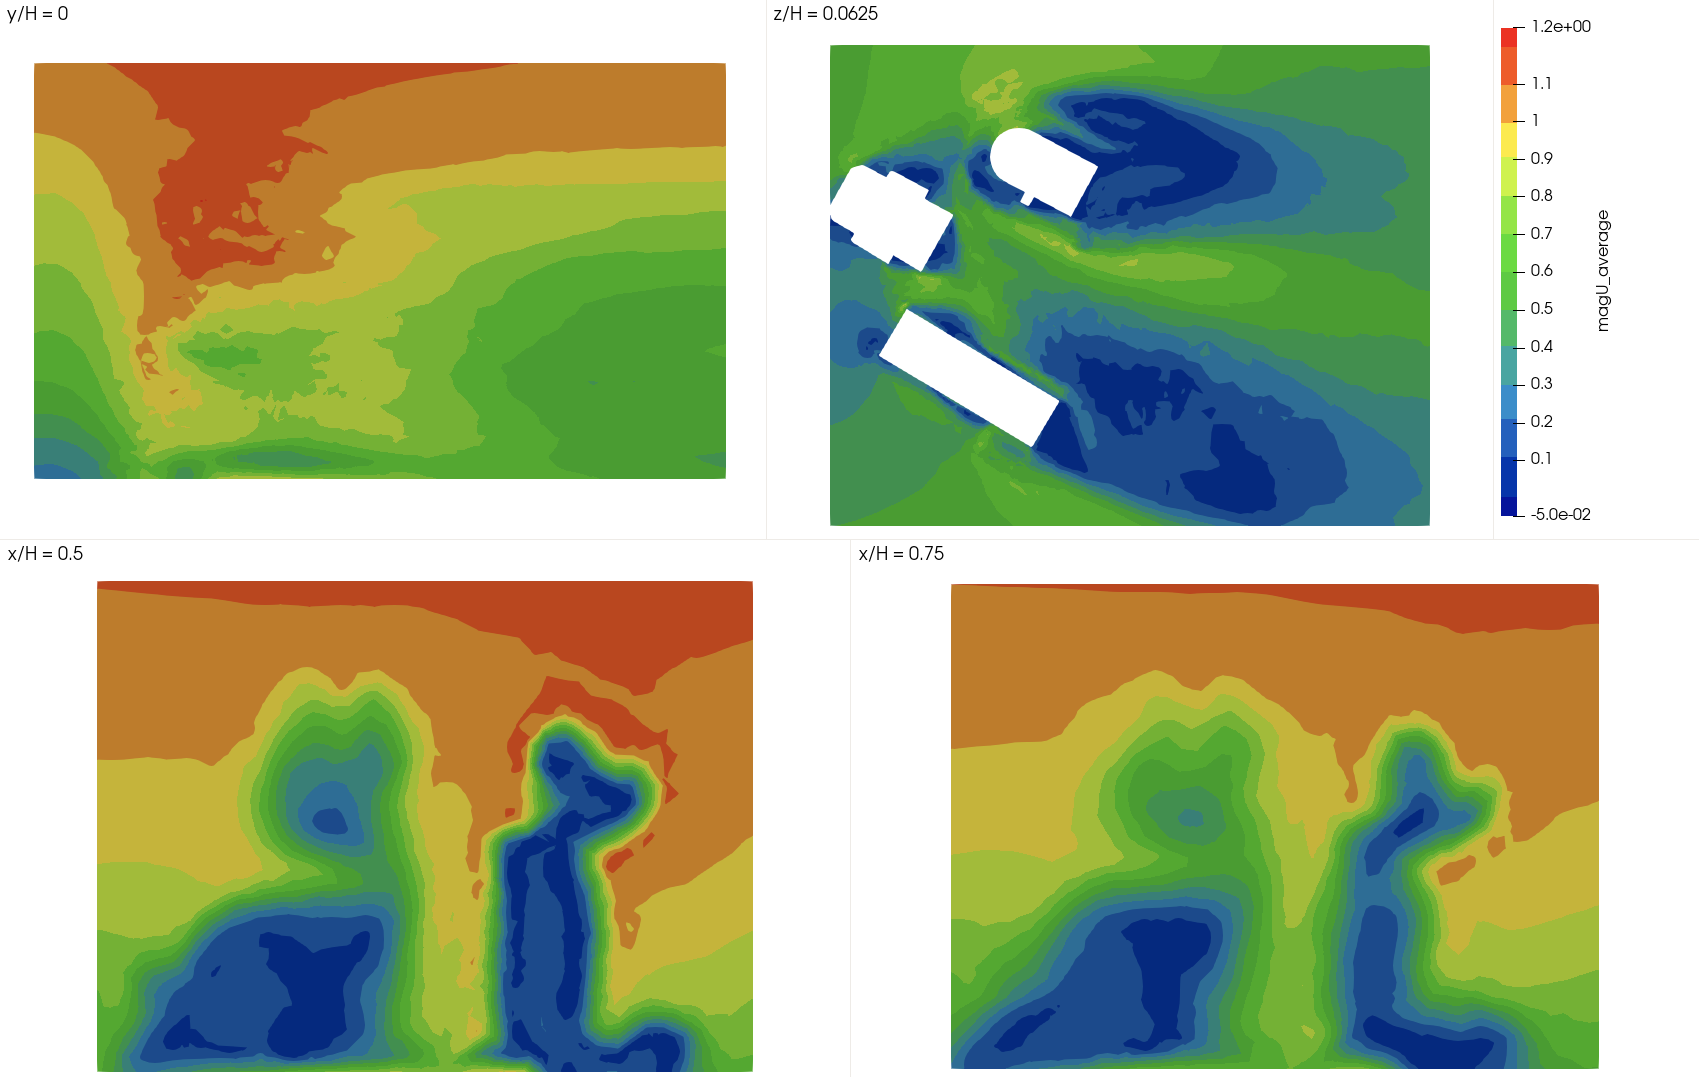

In [ ]:
from IPython.display import Image
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython pvScripts/contourSlices.py
Image('images/contourSlices.png')

Writing
Exiting


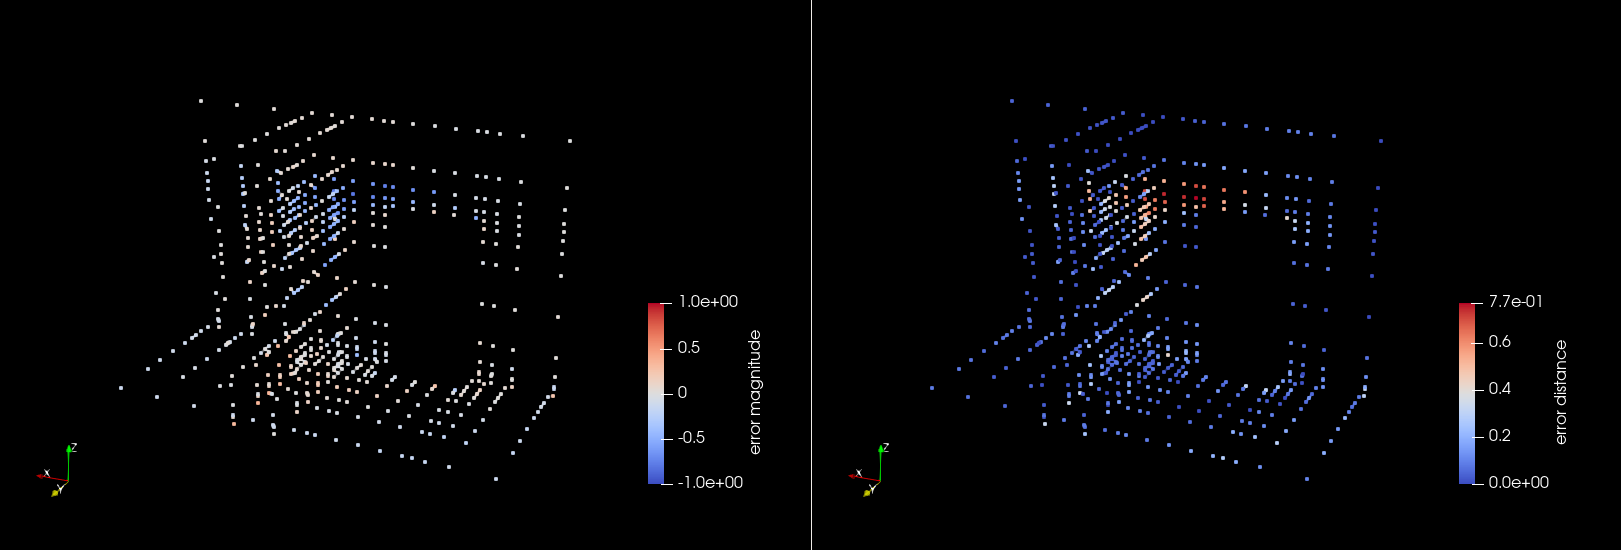

In [ ]:
from IPython.display import Image
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython pvScripts/errInPoints.py
Image('images/errorinpoints.png')

Rendering: convergence
Exiting


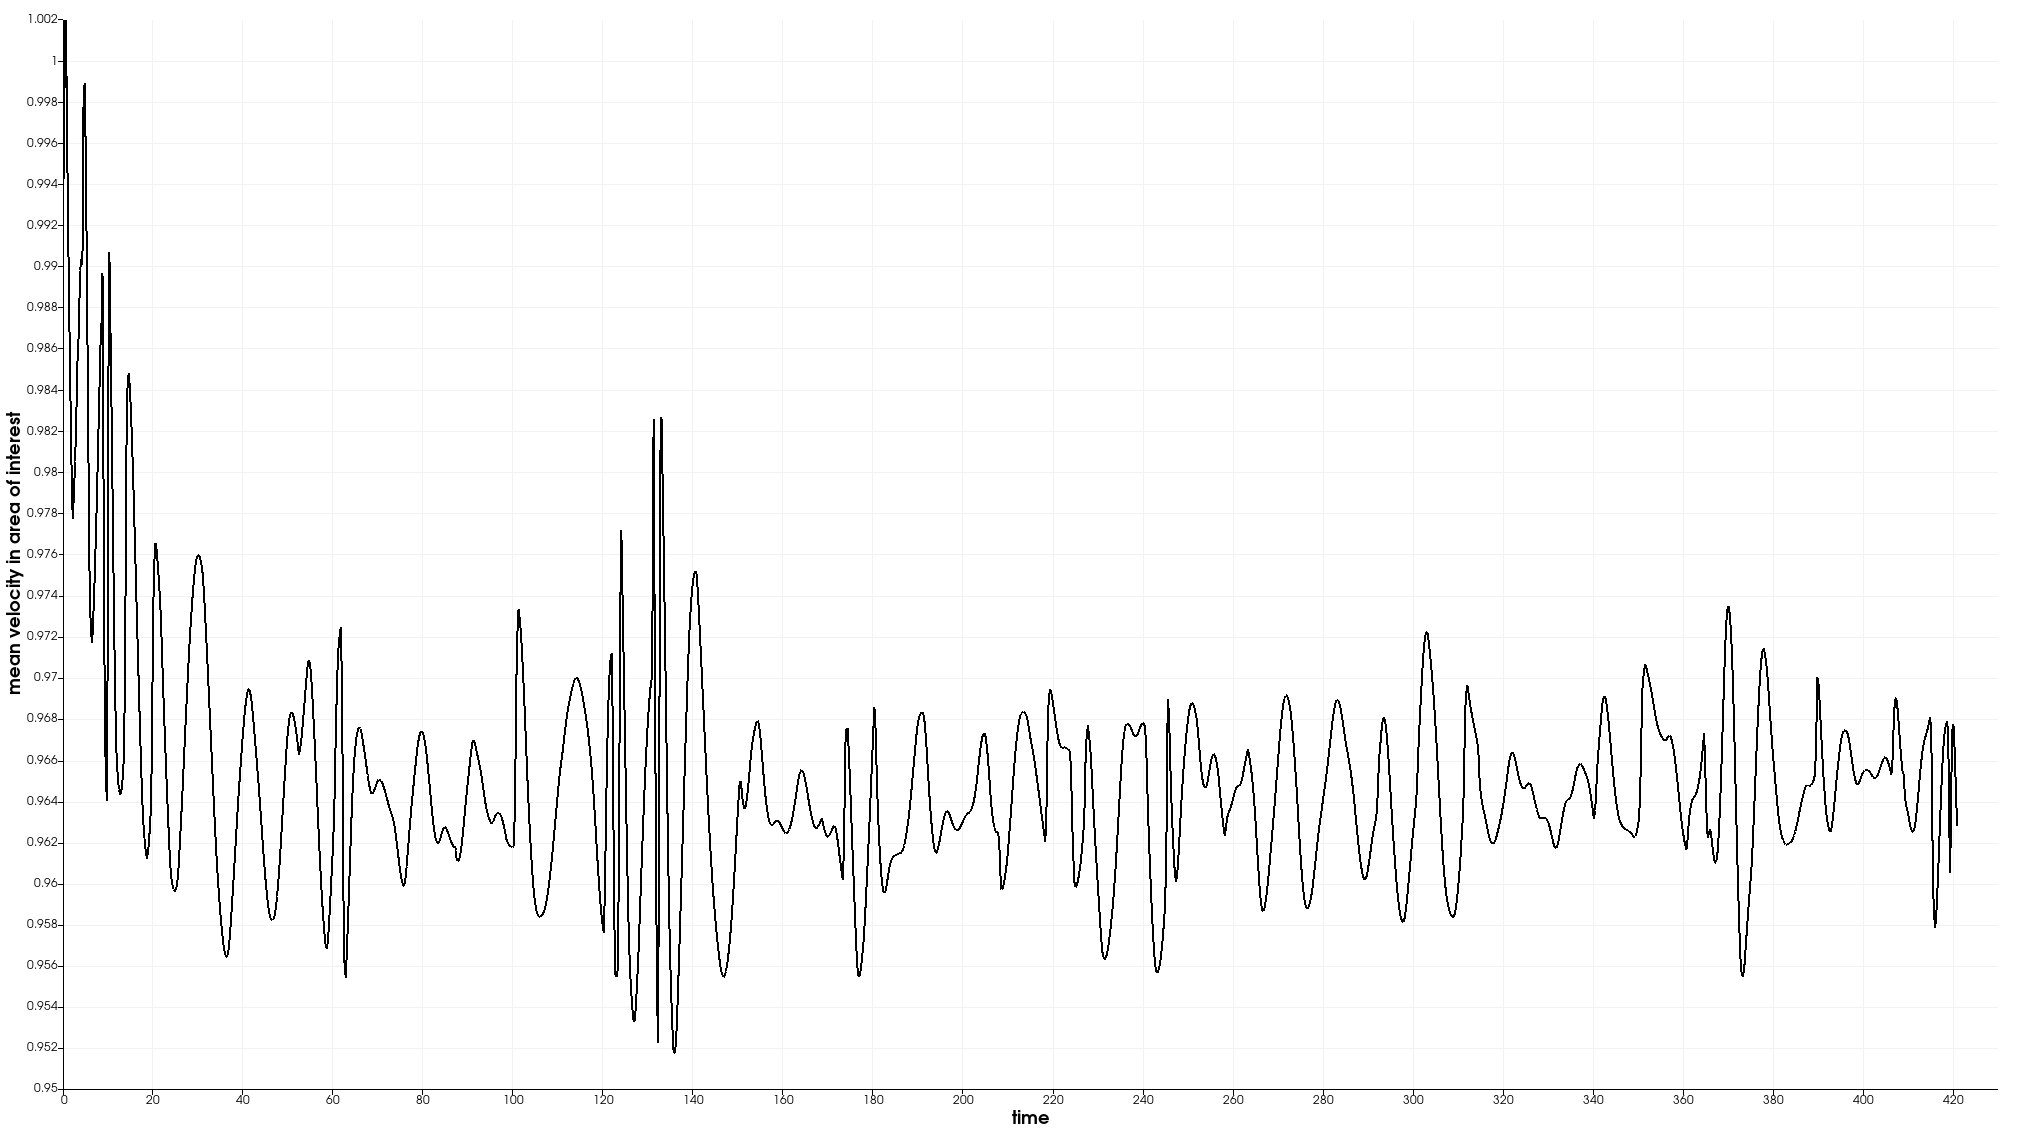

In [ ]:
from IPython.display import Image
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython pvScripts/convergence.py
Image('images/convergence.png')

Rendering 299.7455778702812
Exiting


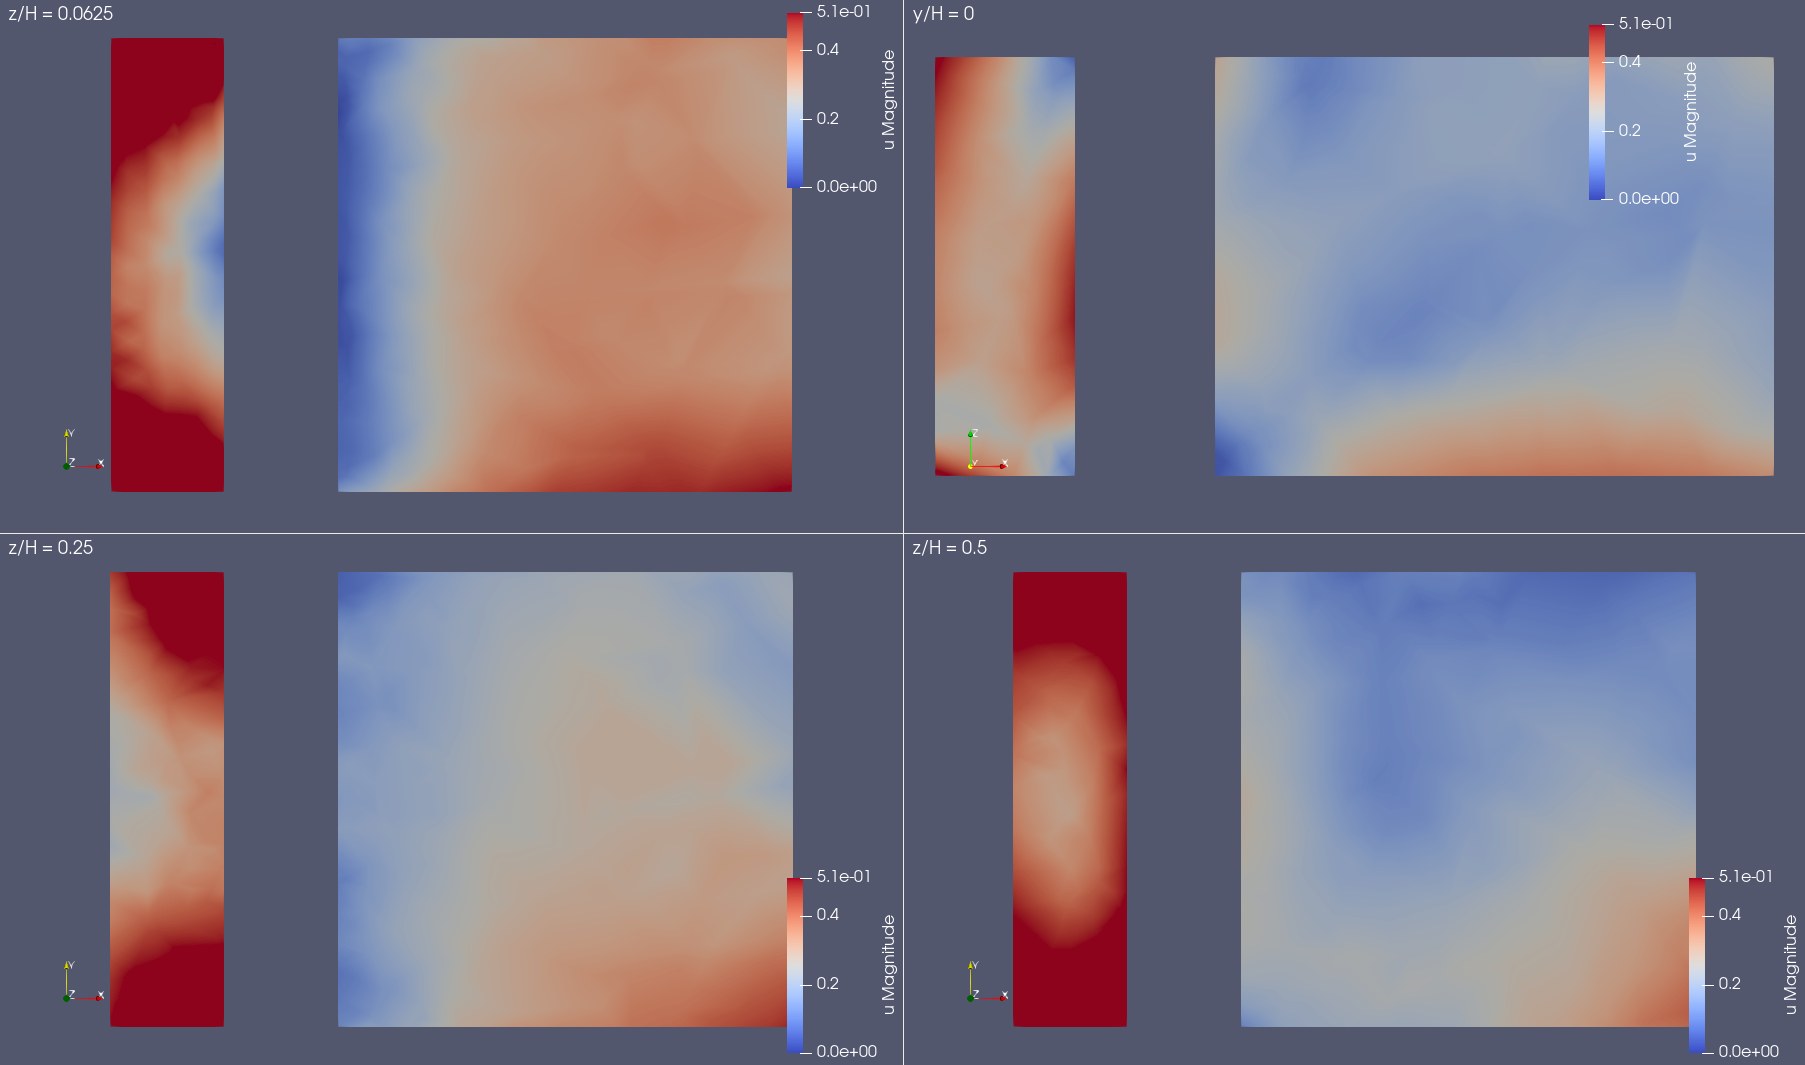

In [ ]:
from IPython.display import Image
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython pvScripts/slices.py
Image('images/slices.png')

Rendering: mesh with 219382 elements
Exiting


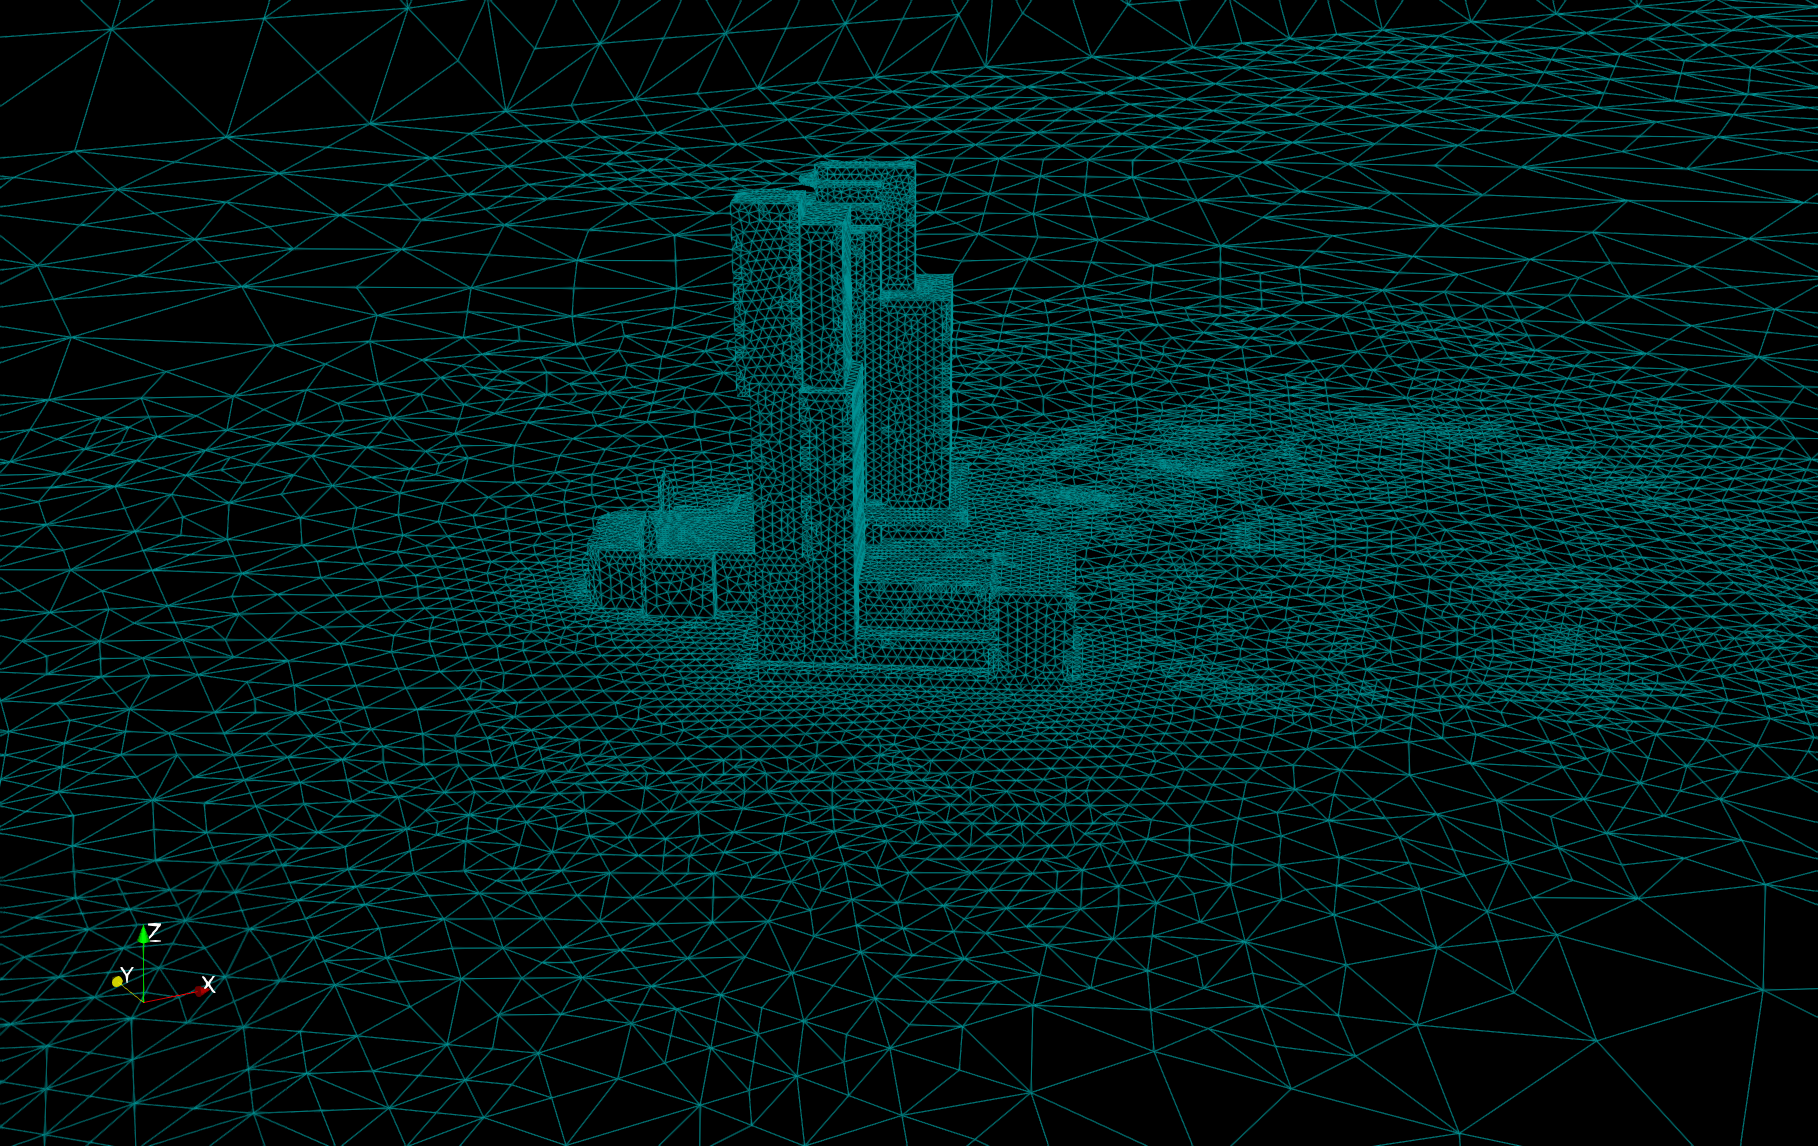

In [ ]:
# mesh after refinement
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython pvScripts/surface_mesh.py
# !cp images/surfaceMesh.png surfaceMeshBefore.png #copy outside of images folder so it won't get removed
# visualisation of the geometry
Image('images/surfaceMesh.png', width = 1000)

Writing
Exiting


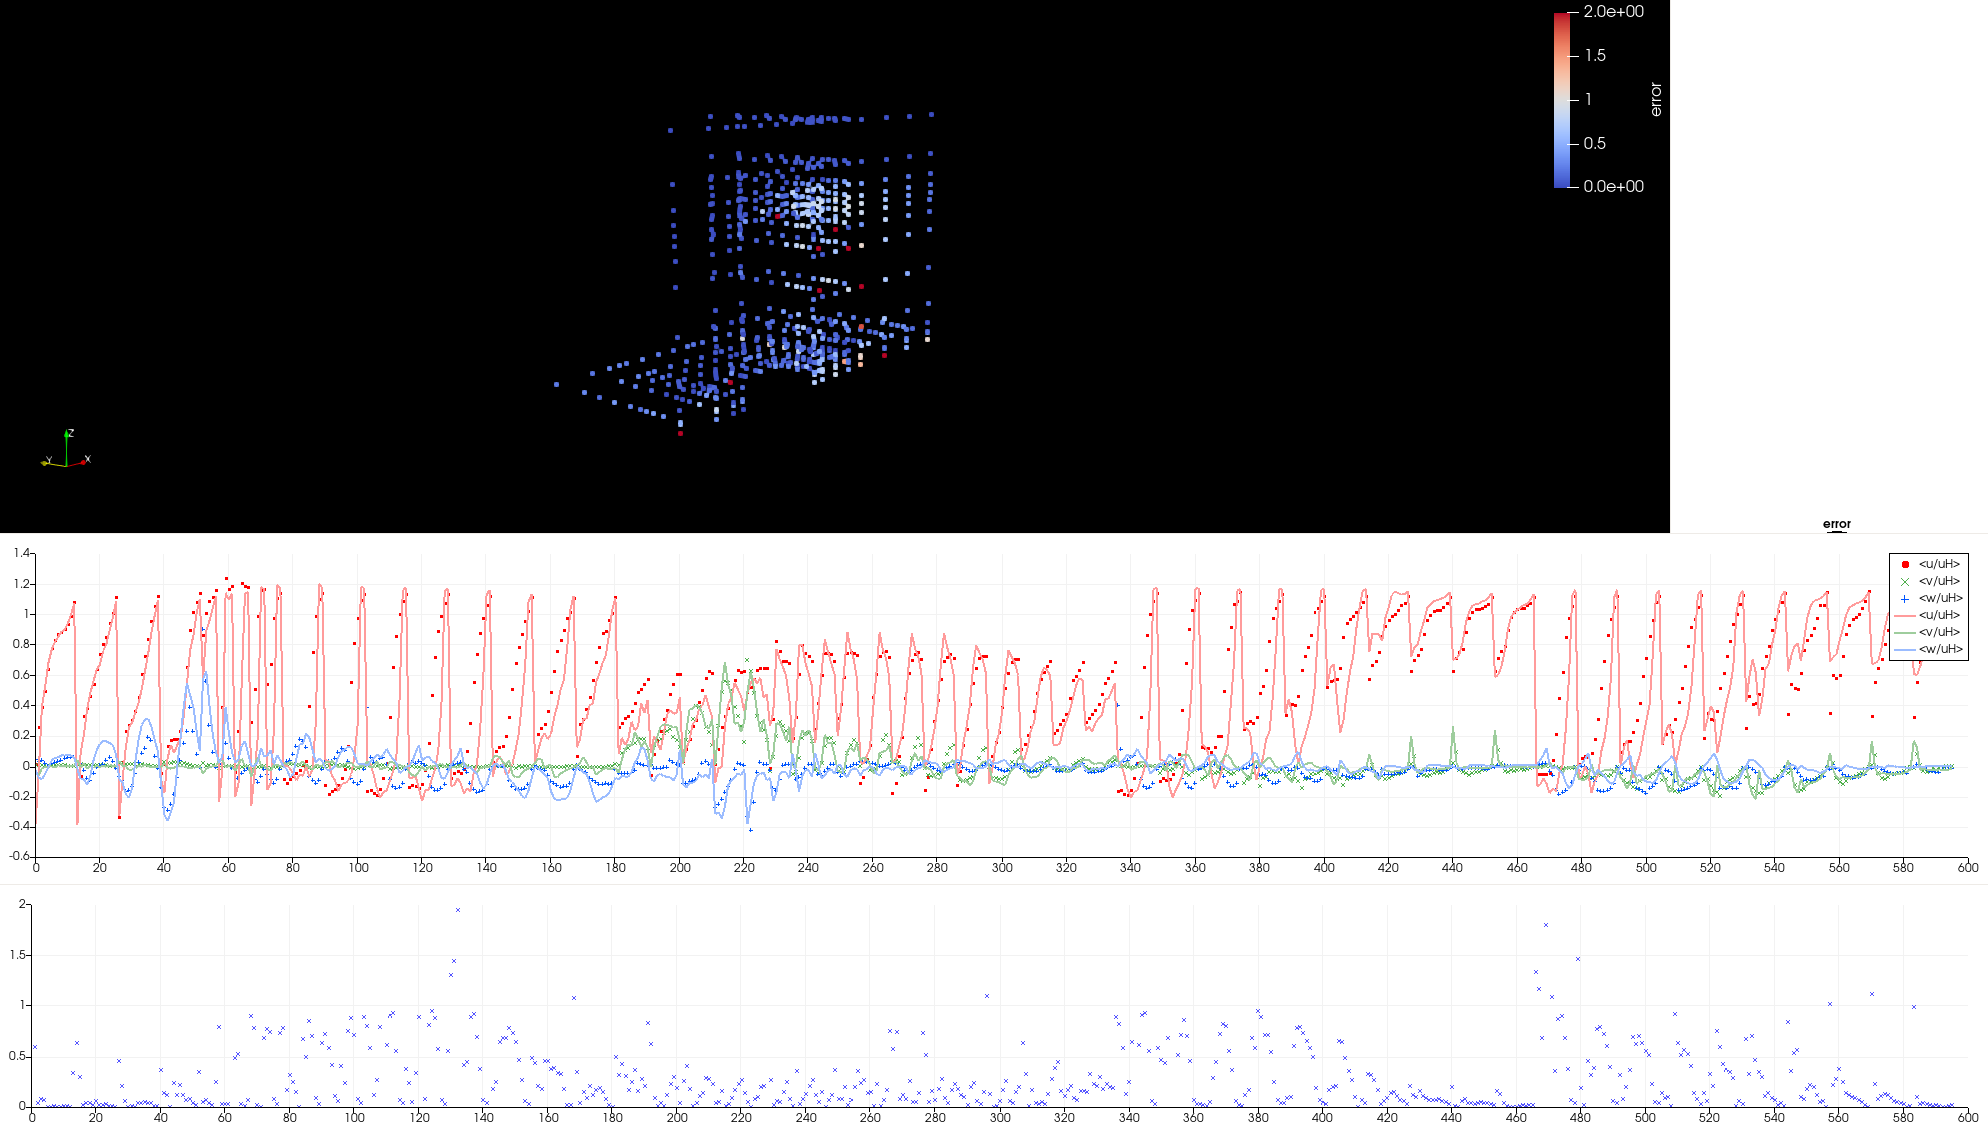

In [ ]:
# Comparison of results to validation data
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython pvScripts/validation.py
Image('images/validation.png')

Rendering: 420.7947747993783
Exiting


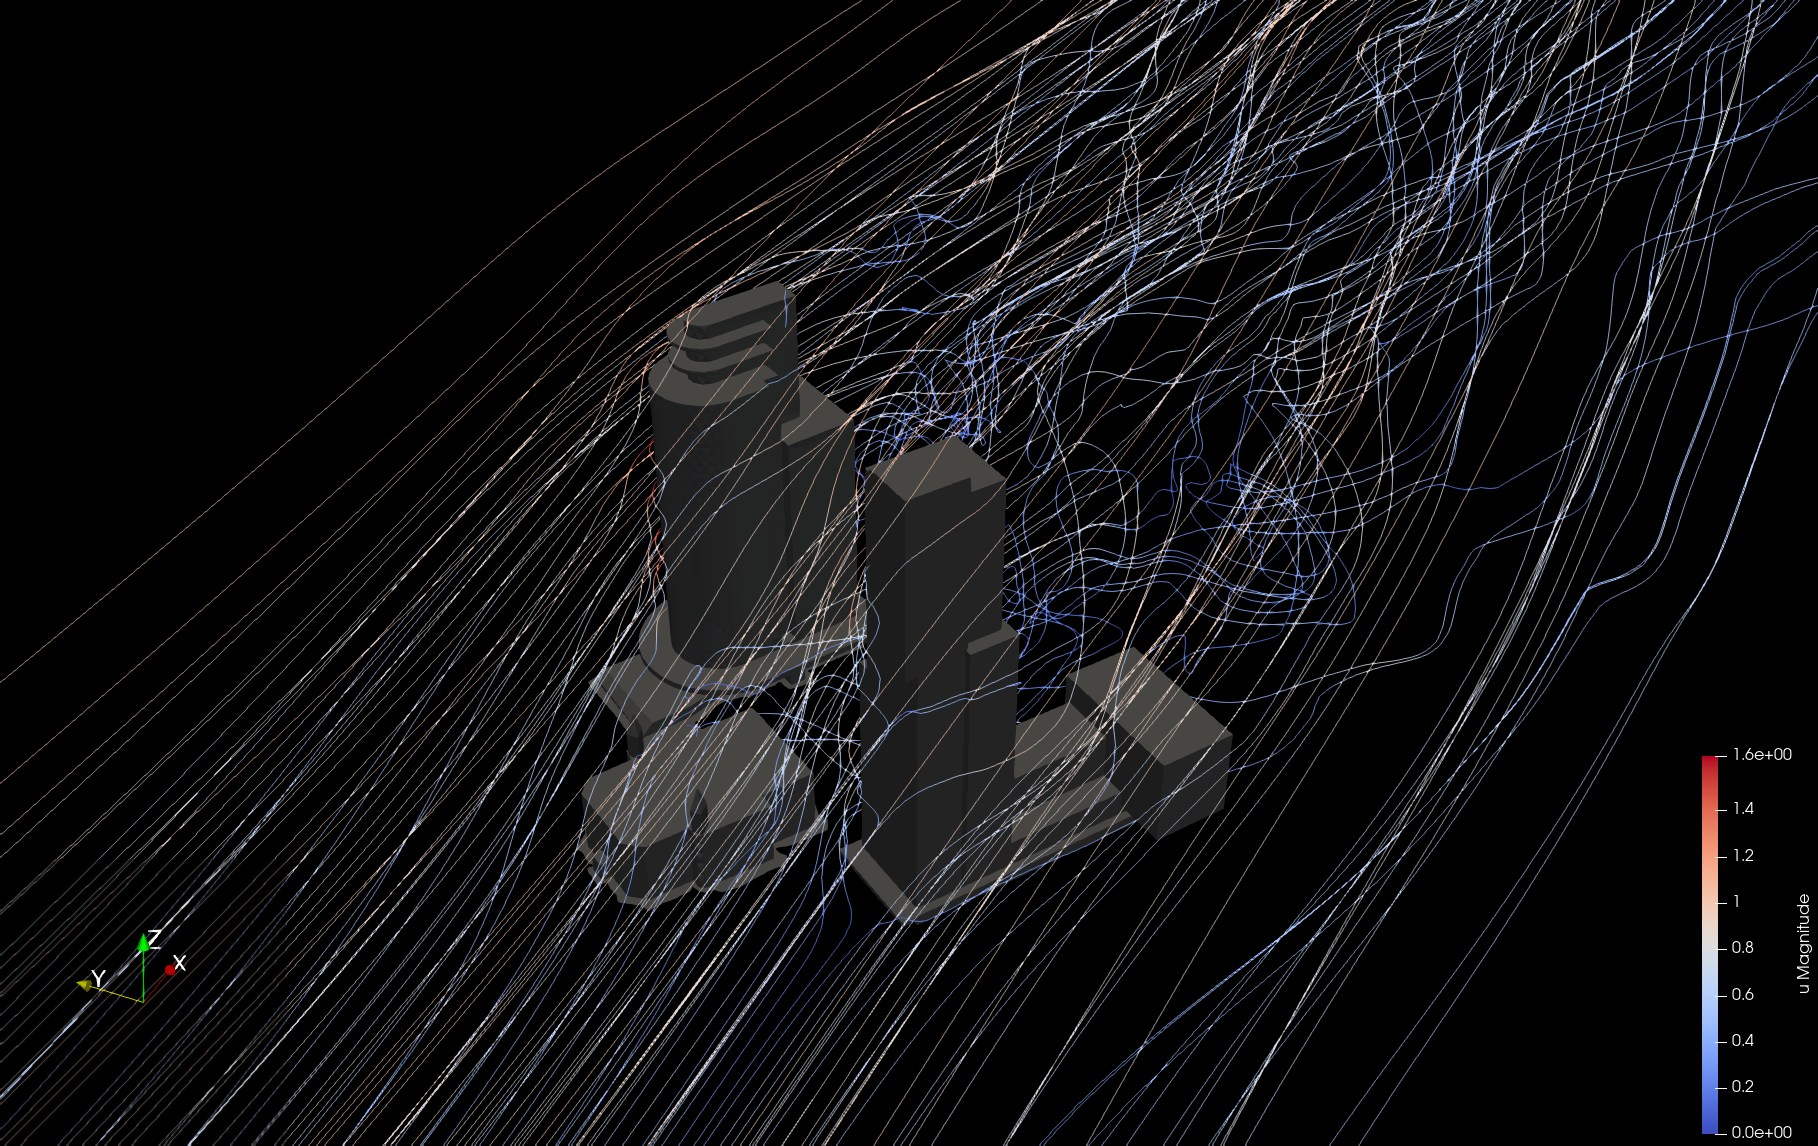

In [ ]:
# 3D visualisation of streamlines around the buildings
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython pvScripts/streamline.py
Image('images/streamline.png', width = 1000)

Rendering: mesh with 192101 elements
Exiting


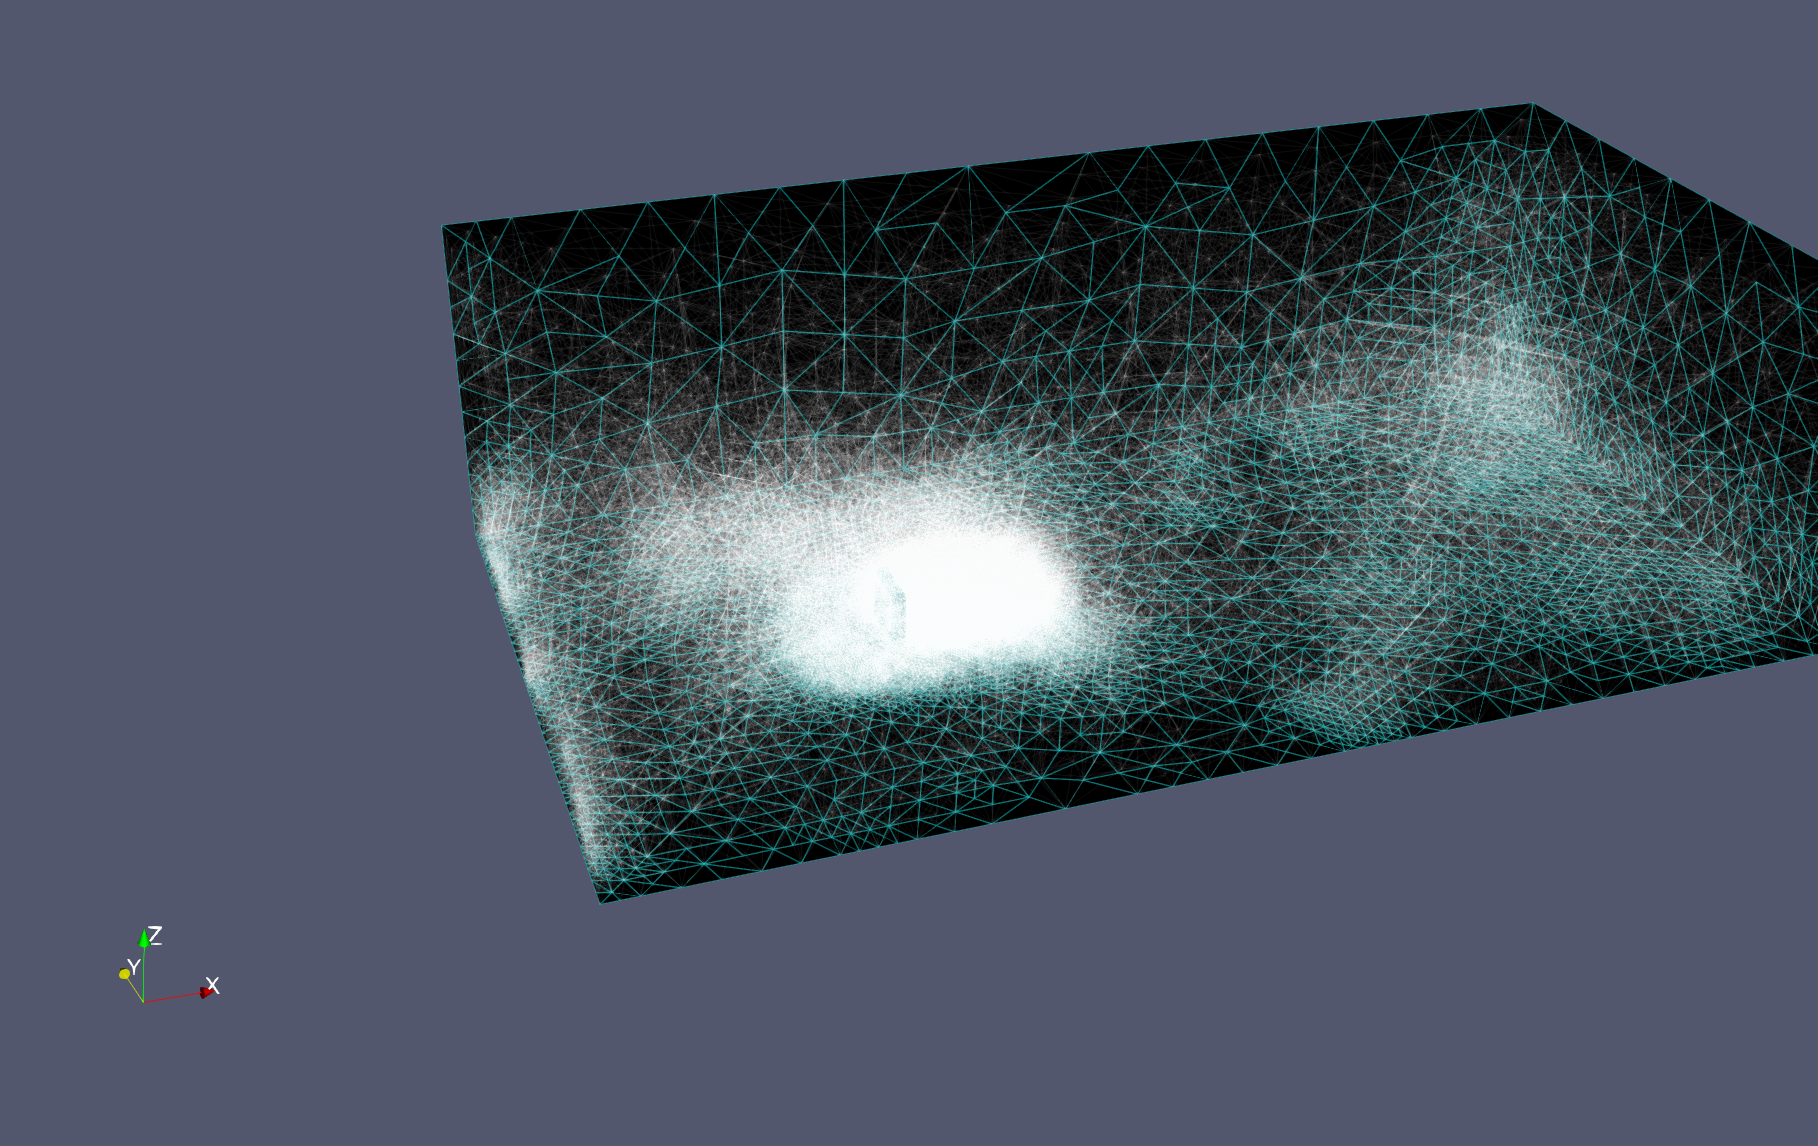

In [ ]:
!/content/ParaView-5.9.0-osmesa-MPI-Linux-Python3.8-64bit/bin/pvpython pvScripts/mesh.py
# visualisation of the mesh before refinement
Image('images/mesh.png', width = 1000)